<a href="https://colab.research.google.com/github/Makerov/Adult_Income_Raiff/blob/main/income_forecast_(with_out_educational_num).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подключение к БД

In [1]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt
!sudo apt update && sudo apt install --yes python3 python3-pip && \
!pip3 install psycopg2-binary

--2023-02-26 05:51:20--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-02-26 05:51:22 (449 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 https://develope

Подключение библиотек и выгрузка датасета

In [2]:
import psycopg2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

conn = psycopg2.connect("""
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""")

query = "SELECT * from public.adult_income"
data = pd.read_sql_query(query, conn)

conn.close()

data.head(9)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0.0,0.0,40.0,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103.0,0.0,32.0,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K


In [3]:
data.shape

(9615, 15)

In [4]:
data.dtypes

age                  int64
workclass           object
fnlwgt               int64
education           object
educational-num      int64
marital-status      object
occupation          object
relationship        object
race                object
gender              object
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country      object
income              object
dtype: object

## Сохранение данных

In [ ]:
data.to_csv("clients_class.csv", index=False)

### Разведочный анализ данных

## 1. Оценка качества данных
* пропущенные значения
* ошибочные значения

In [5]:
len(data)

9615

##### Посмотрим, есть ли в данных пропущенные значения.

In [6]:
data.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               1
gender             1
capital-gain       1
capital-loss       1
hours-per-week     1
native-country     1
income             1
dtype: int64

##### Проверим встречающиеся значения в переменных с пропусками

In [7]:
data['occupation'].value_counts()

# data["educational-num"] = data["educational-num"].astype(object)
# data["capital-gain"].fillna(data['capital-gain'].mean(), inplace=True)
# data["capital-gain"].head()# = data["capital-gain"].astype(str)
# data['capital-gain'].mean()

Prof-specialty       1222
Exec-managerial      1213
Craft-repair         1183
Adm-clerical         1079
Sales                1066
Other-service         960
Machine-op-inspct     621
?                     585
Transport-moving      429
Handlers-cleaners     414
Farming-fishing       310
Tech-support          279
Protective-serv       194
Priv-house-serv        57
Armed-Forces            3
Name: occupation, dtype: int64

##### Заполним пропуски в столбцах: race, gender, capital-gain, capital-loss, hours-per-week, native-country, income

In [8]:

data["workclass"].replace('?', 'Other', inplace=True)
data["occupation"].replace('?', 'Other', inplace=True)
data["race"].fillna('White', inplace=True)
data["gender"].fillna('Male', inplace=True)
data["capital-gain"].fillna(data['capital-gain'].median(), inplace=True)
data["capital-loss"].fillna(data['capital-loss'].median(), inplace=True)
data["hours-per-week"].fillna(data['hours-per-week'].median(), inplace=True)
data["native-country"].fillna('United-States', inplace=True)
data["native-country"].replace('?', 'Other', inplace=True)
data["income"].fillna('<=50K', inplace=True)
data['income'].replace(['<=50K', '>50K'], [0, 1], inplace=True)
data["educational-num"] = data["educational-num"].astype(object)

# data["educational-num"].astype(object)

# data.head()

##### Основные числовые характеристики

In [9]:
# data['income'].value_counts()
data.describe()

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,income
count,9615.000000,9.615000e+03,9615.000000,9615.000000,9615.000000,9615.000000
mean,38.732397,1.882881e+05,1121.881539,87.917525,40.522933,0.234841
std,13.842364,1.051318e+05,7890.176170,404.065626,12.415576,0.423922
min,17.000000,1.376900e+04,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.154725e+05,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.778390e+05,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.374070e+05,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,99999.000000,3770.000000,99.000000,1.000000


In [10]:
data.describe(include='object') # включение категориальных колонок

,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,native-country
count,9615,9615,9615,9615,9615,9615,9615,9615,9615
unique,9,16,16,7,15,6,5,2,41
top,Private,HS-grad,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,6574,3121,3121,4307,1222,3800,8256,6410,8682


In [13]:
corr = data.corr() # построение матрицы корреляций

corr.style.background_gradient(cmap='coolwarm')

,age,capital-gain,capital-loss,hours-per-week,income
age,1.000000,0.082347,0.052406,0.081722,0.224197
capital-gain,0.082347,1.000000,-0.030941,0.098912,0.222003
capital-loss,0.052406,-0.030941,1.000000,0.056344,0.139786
hours-per-week,0.081722,0.098912,0.056344,1.000000,0.228855
income,0.224197,0.222003,0.139786,0.228855,1.000000


##### Столбец Income слабее всего коррелирует с fnlwgt, исключим его из датасета

In [12]:
data.drop(['fnlwgt'], axis=1, inplace=True)

### Визуализация

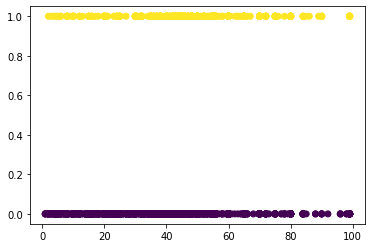

In [14]:
import matplotlib.pyplot as plt

plt.scatter(data['hours-per-week'], data['income'], c=data['income'])

In [15]:
data.groupby('income')['hours-per-week'].mean()

income
0    38.948892
1    45.651461
Name: hours-per-week, dtype: float64

### Обучение модели

##### Разделение на целевую переменную и признаки

In [16]:
X = data.drop('income', axis=1) # матрица объект-признак
y = data['income'] # целевая переменная

##### Перед обучением выкенем не числовые признаки

In [17]:
X.drop(['workclass', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country'], axis=1, inplace=True)

##### Разобъём дата-сет на обучающую выборку и тестовую 75/25

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

##### Необходимо произвести масштабирование

In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(Xtrain)

Xtrain = pd.DataFrame(ss.transform(Xtrain), columns=X.columns)
Xtest = pd.DataFrame(ss.transform(Xtest), columns=X.columns)

Xtrain.head()

,age,capital-gain,capital-loss,hours-per-week
0,0.520223,-0.142379,-0.218738,-0.040793
1,-1.429608,-0.142379,3.746918,-0.845606
2,-0.996312,-0.142379,-0.218738,0.764020
3,0.159144,-0.142379,-0.218738,-0.845606
4,-1.357392,-0.142379,-0.218738,-0.040793


##### Обучим логистическую регрессию

In [20]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression() # объявление модели
model.fit(Xtrain, ytrain) # обучение модели

LogisticRegression()

##### Теперь по результатам модель делает предсказания

In [21]:
pred_test = model.predict(Xtest) # предсказание классов

##### Просмотр результатов тестов

In [22]:
pred_test # просмотр результатов в переменной

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
accuracy_score(ytest, pred_test)

0.790765391014975

In [24]:
y.value_counts()

0    7357
1    2258
Name: income, dtype: int64

In [25]:
pred_test[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])

In [26]:
ytest.head(20)

9500    0
2012    0
367     1
9608    0
4634    0
5229    0
1880    0
1833    0
251     0
543     1
4514    0
1402    1
4161    1
1732    1
782     0
3872    0
4742    0
5753    0
3445    0
1919    0
Name: income, dtype: int64

## Валидация модели

In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix(ytest, pred_test)

array([[1756,   59],
       [ 444,  145]])

In [28]:
ytest.value_counts()

0    1815
1     589
Name: income, dtype: int64

##### Считаем recall (полнота) - показывает, какую долю клиентов с зарплатой >50K нашла модель
##### ( TP / TP + FN = 145 / 145 + 444 )

In [29]:
from sklearn.metrics import recall_score

recall_score(ytest, pred_test)

0.2461799660441426

##### Считаем precision (точность) - показывает, какую долю клиентов действительно с зарплатой >50K из тех, что модель определила как >50K
##### ( TP / TP + FP = 145 / 145 + 59 )

In [30]:
from sklearn.metrics import precision_score

precision_score(ytest, pred_test)

0.7107843137254902

##### Проверим вероятности, выдаваемые моделью

In [31]:
probs = model.predict_proba(Xtest)

probs[:10]

array([[0.89941142, 0.10058858],
       [0.70267931, 0.29732069],
       [0.65100673, 0.34899327],
       [0.91369703, 0.08630297],
       [0.75007659, 0.24992341],
       [0.51054282, 0.48945718],
       [0.88066559, 0.11933441],
       [0.81842764, 0.18157236],
       [0.79790315, 0.20209685],
       [0.84727885, 0.15272115]])

##### Пробуем изменить порог для перевода вероятности в классы с 0.5 до 0.3

In [32]:
probs_income = probs[:,1]

classes = probs_income > 0.3

In [33]:
confusion_matrix(ytest, classes)

array([[1590,  225],
       [ 324,  265]])

In [34]:
ytest.value_counts()

0    1815
1     589
Name: income, dtype: int64

In [35]:
recall_score(ytest, classes)

0.44991511035653653

In [36]:
from sklearn.metrics import precision_score

precision_score(ytest, classes)

0.5408163265306123

### Интерпретация модели

##### После обучения модели, можно посмотреть на её веса, то есть на коэффициенты при признаках, найденные моделью

In [37]:
model.coef_, model.intercept_

(array([[0.47265279, 2.5053824 , 0.29222569, 0.50749927]]),
 array([-1.21076667]))

In [39]:
import pandas as pd

coef_table = pd.DataFrame({'features' : list(X.columns), 'weights' : list(model.coef_[0])})

coef_table.sort_values(by='weights')

,features,weights
2,capital-loss,0.292226
0,age,0.472653
3,hours-per-week,0.507499
1,capital-gain,2.505382


### Градиентный бустинг

##### Посчитаем качество логистической регрессии

In [40]:
from sklearn import metrics

print('LR quality')
print('precision: ', metrics.precision_score(ytest, classes))
print('recall: ', metrics.recall_score(ytest, classes))
print('auc-roc: ', metrics.roc_auc_score(ytest, probs[:, 1]))

LR quality
precision:  0.5408163265306123
recall:  0.44991511035653653
auc-roc:  0.7806512415402677


##### Установка CatBoost для использования градиентного бустинга

In [41]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.9 MB/s eta 0:00:00


In [42]:
from catboost import CatBoostClassifier, Pool

In [43]:
train_set = Pool(Xtrain, ytrain)
test_set = Pool(Xtest, ytest)

In [49]:
gbm = CatBoostClassifier(iterations=600,  # сколько деревьев
                          depth=2,        # глубина каждого дерева
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)     # обучение
gbm_preds = gbm.predict_proba(Xtest)      # предсказание

##### Построим график, который отображает качество модели на тестовой выборке по мере добавления деревьев

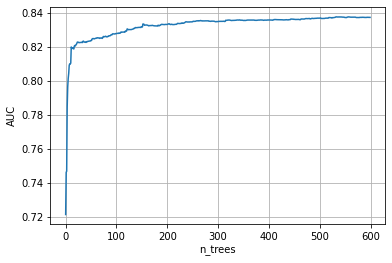

In [50]:
eval_metrics = gbm.get_evals_result()
plt.plot(eval_metrics['validation']['AUC'])
plt.xlabel('n_trees')
plt.ylabel('AUC')
plt.grid()

##### Посчитаем качество градиентного бустинга

In [57]:
gbm_classes = (gbm_preds[:, 1] > 0.4)
print('precision: ', metrics.precision_score(ytest, gbm_classes))
print('recall: ', metrics.recall_score(ytest, gbm_classes))
print('auc-roc: ', metrics.roc_auc_score(ytest, gbm_preds[:, 1]))

precision:  0.6855670103092784
recall:  0.45161290322580644
auc-roc:  0.8376591973134649


##### Важность признаков

In [58]:
coef_table = pd.DataFrame({'features' : list(X.columns), 'importances' : list(gbm.get_feature_importance())})

coef_table.sort_values(by='importances')

,features,importances
3,hours-per-week,12.647400
2,capital-loss,14.456026
1,capital-gain,33.010987
0,age,39.885587


## Обработка категориальных признаков

In [61]:
X_full = data.drop(['income', 'educational-num'], axis=1)

In [62]:
Xtrain_categ, Xtest_categ, ytrain_categ, ytest_categ = train_test_split(X_full, y, test_size=0.25, random_state=42)

In [63]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
numeric_features = X.columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

X_transformed = column_transformer.fit_transform(Xtrain_categ)
X_test_transformed = column_transformer.transform(Xtest_categ)

In [64]:
X_transformed.shape

(7211, 105)

##### Обучение линейной регресси с категориальными признаками

In [65]:
model = LogisticRegression()
model.fit(X_transformed, ytrain_categ)
pred = model.predict_proba(X_test_transformed)

In [71]:
classes = (pred[:, 1] > 0.5)
print('precision: ', metrics.precision_score(ytest_categ, classes))
print('recall: ', metrics.recall_score(ytest_categ, classes))
print('auc-roc: ', metrics.roc_auc_score(ytest_categ, pred[:, 1]))

precision:  0.7399103139013453
recall:  0.5602716468590832
auc-roc:  0.9010626406057798


##### Обучение градиентного бустинга с категориальными признаками

In [72]:
train_set = Pool(X_transformed, ytrain_categ)
test_set = Pool(X_test_transformed, ytest_categ)
gbm = CatBoostClassifier(iterations=100,
                          depth=2,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(test_set)
gbm_classes = (gbm_preds[:, 1] > 0.5)
print('precision: ', metrics.precision_score(ytest_categ, gbm_classes))
print('recall: ', metrics.recall_score(ytest_categ, gbm_classes))
print('auc-roc: ', metrics.roc_auc_score(ytest_categ, gbm_preds[:, 1]))

precision:  0.7994791666666666
recall:  0.5212224108658744
auc-roc:  0.9092475924548775
